In [ ]:
# Import library yang digunakan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
# --- 1. DATA PREPARATION ---

daftarProvinsi = [
    "ACEH", "SUMATERA UTARA", "SUMATERA BARAT", "RIAU", "JAMBI", "SUMATERA SELATAN",
    "BENGKULU", "LAMPUNG", "KEP. BANGKA BELITUNG", "KEPULAUAN RIAU", "DKI JAKARTA",
    "JAWA BARAT", "JAWA TENGAH", "DI YOGYAKARTA", "JAWA TIMUR", "BANTEN", "BALI",
    "NUSA TENGGARA BARAT", "NUSA TENGGARA TIMUR", "KALIMANTAN BARAT", "KALIMANTAN TENGAH",
    "KALIMANTAN SELATAN", "KALIMANTAN TIMUR", "KALIMANTAN UTARA", "SULAWESI UTARA",
    "SULAWESI TENGAH", "SULAWESI SELATAN", "SULAWESI TENGGARA", "GORONTALO",
    "SULAWESI BARAT", "MALUKU", "MALUKU UTARA", "PAPUA", "PAPUA BARAT",
    "PAPUA TENGAH", "PAPUA PEGUNUNGAN", "PAPUA SELATAN", "PAPUA BARAT DAYA"
]

tahunProses = [2022, 2023, 2024]
pathDasar = './Raw Data/'
provinsiIndukPapua = ["PAPUA", "PAPUA BARAT"]
provinsiBaruPapua = ["PAPUA TENGAH", "PAPUA PEGUNUNGAN", "PAPUA SELATAN", "PAPUA BARAT DAYA"]

In [ ]:
listDataPerTahun = []
for tahun in tahunProses:
    dataPengeluaran = (
        pd.read_csv(f'{pathDasar}[Metode Baru] Pengeluaran per Kapita Disesuaikan, {tahun}.csv', skiprows=1)
        .rename(columns={'Unnamed: 0': 'Provinsi','[Metode Baru] Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)': 'Pengeluaran per Kapita Disesuaikan (PPP)'})
        .assign(Provinsi=lambda df: df['Provinsi'].str.upper().replace({"D I YOGYAKARTA": "DI YOGYAKARTA"}))
        .drop_duplicates(subset=['Provinsi'], keep='first').query("Provinsi in @daftarProvinsi").assign(Tahun=tahun)
    )
    dataPendidikan = (
        pd.read_csv(f'{pathDasar}Rata-Rata Lama Sekolah Penduduk Umur 15 Tahun ke Atas Menurut Provinsi, {tahun}.csv', skiprows=1)
        .rename(columns={'Unnamed: 0': 'Provinsi','Rata-Rata Lama Sekolah Penduduk Umur 15 Tahun ke Atas Menurut Provinsi': 'Rata-Rata Lama Sekolah (RLS)'})
        .assign(Provinsi=lambda df: df['Provinsi'].str.upper().replace({"KEP. RIAU": "KEPULAUAN RIAU"}))
        .drop_duplicates(subset=['Provinsi'], keep='first').query("Provinsi in @daftarProvinsi").assign(Tahun=tahun)
    )
    dataAhh = pd.read_csv(f'{pathDasar}Angka Harapan Hidup (AHH) Menurut Provinsi dan Jenis Kelamin (menggunakan UHH hasil SP2020 LF), {tahun}.csv', skiprows=2)
    dataAhh = dataAhh.rename(columns={'Unnamed: 0': 'Provinsi'})
    dataAhh['Angka Harapan Hidup (AHH)'] = (pd.to_numeric(dataAhh['Laki-laki'], errors='coerce') + pd.to_numeric(dataAhh['Perempuan'], errors='coerce')) / 2
    dataAhh = dataAhh.assign(Provinsi=lambda df: df['Provinsi'].str.upper().replace({"KEP. RIAU": "KEPULAUAN RIAU"}))
    dataAhh = dataAhh.drop_duplicates(subset=['Provinsi'], keep='first').query("Provinsi in @daftarProvinsi").assign(Tahun=tahun)

    listDfTahunan = [
        dataPengeluaran[['Provinsi', 'Tahun', 'Pengeluaran per Kapita Disesuaikan (PPP)']],
        dataPendidikan[['Provinsi', 'Tahun', 'Rata-Rata Lama Sekolah (RLS)']],
        dataAhh[['Provinsi', 'Tahun', 'Angka Harapan Hidup (AHH)']]
    ]
    dataTahunGabung = reduce(lambda kiri, kanan: pd.merge(kiri, kanan, on=['Provinsi', 'Tahun'], how='outer'), listDfTahunan)
    listDataPerTahun.append(dataTahunGabung)

dataGabungan = pd.concat(listDataPerTahun, ignore_index=True).drop_duplicates()

dataGabungan['Pengeluaran per Kapita Disesuaikan (PPP)'] = pd.to_numeric(
    dataGabungan['Pengeluaran per Kapita Disesuaikan (PPP)'], errors='coerce'
)
dataGabungan['Rata-Rata Lama Sekolah (RLS)'] = pd.to_numeric(
    dataGabungan['Rata-Rata Lama Sekolah (RLS)'], errors='coerce'
)

In [ ]:
# --- Pengecekan Missing Value (Sebelum Imputasi) ---
print("\n--- Pengecekan Missing Value (Sebelum Imputasi) ---")
missingValuesSebelum = dataGabungan.isnull().sum()
print("Jumlah missing value per kolom:")
# Hanya tampilkan kolom yang memiliki missing value
print(missingValuesSebelum[missingValuesSebelum > 0])
print("-" * 50)

# --- Imputasi Nilai Kosong Papua ---
kolomUntukImputasi = ['Pengeluaran per Kapita Disesuaikan (PPP)', 'Rata-Rata Lama Sekolah (RLS)', 'Angka Harapan Hidup (AHH)']
for kolom in kolomUntukImputasi:
    for tahun in tahunProses:
        rerataInduk = dataGabungan[(dataGabungan['Provinsi'].isin(provinsiIndukPapua)) & (dataGabungan['Tahun'] == tahun)][kolom].mean()
        kondisi = ((dataGabungan['Provinsi'].isin(provinsiBaruPapua)) & (dataGabungan['Tahun'] == tahun) & (dataGabungan[kolom].isnull()))
        dataGabungan.loc[kondisi, kolom] = rerataInduk

# --- Pengecekan Missing Value (Setelah Imputasi) ---
print("\n--- Pengecekan Missing Value (Setelah Imputasi) ---")
missingValuesSetelah = dataGabungan[kolomUntukImputasi].isnull().sum()
print("Jumlah missing value di kolom target setelah diisi:")
print(missingValuesSetelah)
print("-" * 50)


--- Pengecekan Missing Value (Sebelum Imputasi) ---
Jumlah missing value per kolom:
Pengeluaran per Kapita Disesuaikan (PPP)    8
Rata-Rata Lama Sekolah (RLS)                8
Angka Harapan Hidup (AHH)                   8
dtype: int64
--------------------------------------------------

--- Pengecekan Missing Value (Setelah Imputasi) ---
Jumlah missing value di kolom target setelah diisi:
Pengeluaran per Kapita Disesuaikan (PPP)    0
Rata-Rata Lama Sekolah (RLS)                0
Angka Harapan Hidup (AHH)                   0
dtype: int64
--------------------------------------------------


In [ ]:
# --- Menampilkan Tabel Sebelum Menghitung IPM ---
dataTampil = dataGabungan.copy()
tipeKategoriProvinsi = pd.CategoricalDtype(categories=daftarProvinsi, ordered=True)
dataTampil['Provinsi'] = dataTampil['Provinsi'].astype(tipeKategoriProvinsi)
dataTampil = dataTampil.sort_values(by=['Provinsi', 'Tahun']).reset_index(drop=True)
dataTampil['Provinsi'] = dataTampil['Provinsi'].astype(str) + ' ' + dataTampil['Tahun'].astype(str)
dataTampil = dataTampil[['Provinsi', 'Pengeluaran per Kapita Disesuaikan (PPP)', 'Rata-Rata Lama Sekolah (RLS)', 'Angka Harapan Hidup (AHH)']]
for kolom in ['Rata-Rata Lama Sekolah (RLS)', 'Angka Harapan Hidup (AHH)']:
    dataTampil[kolom] = pd.to_numeric(dataTampil[kolom], errors='coerce').round(2)

print("\n--- Tabel Setelah Imputasi (Sebelum Perhitungan IPM) ---\n")
#print(dataTampil.to_string(index=False))
display(dataTampil.head(9).style.hide(axis="index"))


--- Tabel Setelah Imputasi (Sebelum Perhitungan IPM) ---



Provinsi,Pengeluaran per Kapita Disesuaikan (PPP),Rata-Rata Lama Sekolah (RLS),Angka Harapan Hidup (AHH)
ACEH 2022,9963.000000,9.790000,72.970000
ACEH 2023,10334.000000,9.890000,73.110000
ACEH 2024,10811.000000,9.950000,73.260000
SUMATERA UTARA 2022,10848.000000,9.990000,73.440000
SUMATERA UTARA 2023,11049.000000,10.070000,73.720000
SUMATERA UTARA 2024,11460.000000,10.180000,73.960000
SUMATERA BARAT 2022,11130.000000,9.510000,73.940000
SUMATERA BARAT 2023,11380.000000,9.590000,74.200000
SUMATERA BARAT 2024,11718.000000,9.720000,74.440000


In [ ]:
# --- Perhitungan IPM ---
def hitungIpm(ppp, rls, ahh):
    pppMin, pppMaks, rlsMin, rlsMaks, ahhMin, ahhMaks = 100, 75000, 0, 15, 20, 85
    indeksPendapatan = (np.log(ppp) - np.log(pppMin)) / (np.log(pppMaks) - np.log(pppMin))
    indeksPendidikan = (rls - rlsMin) / (rlsMaks - rlsMin)
    indeksKesehatan = (ahh - ahhMin) / (ahhMaks - ahhMin)
    return ((indeksPendapatan * indeksPendidikan * indeksKesehatan) ** (1/3) * 100)

# Hitung dan tambahkan kolom IPM
dataGabungan['Indeks Pembangunan Manusia (IPM)'] = hitungIpm(
    dataGabungan['Pengeluaran per Kapita Disesuaikan (PPP)'],
    dataGabungan['Rata-Rata Lama Sekolah (RLS)'],
    dataGabungan['Angka Harapan Hidup (AHH)']
)

# Format nama provinsi + tahun
dataGabungan['Provinsi'] = dataGabungan['Provinsi'].astype(tipeKategoriProvinsi)
dataGabungan = dataGabungan.sort_values(by=['Provinsi', 'Tahun']).reset_index(drop=True)
dataGabungan['Provinsi'] = dataGabungan['Provinsi'].astype(str) + ' ' + dataGabungan['Tahun'].astype(str)

# Ambil kolom yang dibutuhkan untuk klasterisasi
dataFinal = dataGabungan[['Provinsi',
                          'Angka Harapan Hidup (AHH)',
                          'Rata-Rata Lama Sekolah (RLS)',
                          'Pengeluaran per Kapita Disesuaikan (PPP)',
                          'Indeks Pembangunan Manusia (IPM)']].copy()

# Pembulatan angka
dataFinal[['Angka Harapan Hidup (AHH)',
           'Rata-Rata Lama Sekolah (RLS)',
           'Pengeluaran per Kapita Disesuaikan (PPP)',
           'Indeks Pembangunan Manusia (IPM)']] = \
    dataFinal[['Angka Harapan Hidup (AHH)',
               'Rata-Rata Lama Sekolah (RLS)',
               'Pengeluaran per Kapita Disesuaikan (PPP)',
               'Indeks Pembangunan Manusia (IPM)']].round(2)

# Simpan ke file CSV
dataFinal.to_csv('dataPreprocessing.csv', index=False)

print(f"\nData preparation selesai. File disimpan ke dataPreprocessing.csv")
print("\n--- Tabel Final untuk Preprocessing ---\n")
display(dataFinal.head(9).style.hide(axis="index"))



Data preparation selesai. File disimpan ke dataPreprocessing.csv

--- Tabel Final untuk Preprocessing ---



Provinsi,Angka Harapan Hidup (AHH),Rata-Rata Lama Sekolah (RLS),Pengeluaran per Kapita Disesuaikan (PPP),Indeks Pembangunan Manusia (IPM)
ACEH 2022,72.970000,9.790000,9963.000000,71.770000
ACEH 2023,73.110000,9.890000,10334.000000,72.270000
ACEH 2024,73.260000,9.950000,10811.000000,72.710000
SUMATERA UTARA 2022,73.440000,9.990000,10848.000000,72.920000
SUMATERA UTARA 2023,73.720000,10.070000,11049.000000,73.330000
SUMATERA UTARA 2024,73.960000,10.180000,11460.000000,73.890000
SUMATERA BARAT 2022,73.940000,9.510000,11130.000000,72.080000
SUMATERA BARAT 2023,74.200000,9.590000,11380.000000,72.510000
SUMATERA BARAT 2024,74.440000,9.720000,11718.000000,73.090000


In [ ]:
# --- 2. DATA PREPROCESSING ---

# Baca data
dataUntukScaling = pd.read_csv('dataPreprocessing.csv')

# Inisialisasi scaler
scaler = MinMaxScaler()

# Pilih semua kolom numerik untuk di-scaling
fiturNumerik = ['Angka Harapan Hidup (AHH)',
                'Rata-Rata Lama Sekolah (RLS)',
                'Pengeluaran per Kapita Disesuaikan (PPP)',
                'Indeks Pembangunan Manusia (IPM)']

# Simpan hasil scaling dalam DataFrame baru
dataScaled = scaler.fit_transform(dataUntukScaling[fiturNumerik])
dataScaledDF = pd.DataFrame(dataScaled, columns=[col + '_Scaled' for col in fiturNumerik])

# Gabungkan dengan kolom Provinsi
dataUntukScalingScaled = pd.concat([dataUntukScaling[['Provinsi']], dataScaledDF], axis=1)

# Simpan hasilnya
namaFileOutput = 'dataScaled.csv'
dataUntukScalingScaled.to_csv(namaFileOutput, index=False)

print(f"Scaling dengan MinMaxScaler selesai. Data disimpan ke {namaFileOutput}\n")
print("--- Tabel Dengan Semua Fitur yang Sudah di-Scaling ---\n")
display(dataUntukScalingScaled.head(9).style.hide(axis="index"))


Scaling dengan MinMaxScaler selesai. Data disimpan ke dataScaled.csv

--- Tabel Dengan Semua Fitur yang Sudah di-Scaling ---



Provinsi,Angka Harapan Hidup (AHH)_Scaled,Rata-Rata Lama Sekolah (RLS)_Scaled,Pengeluaran per Kapita Disesuaikan (PPP)_Scaled,Indeks Pembangunan Manusia (IPM)_Scaled
ACEH 2022,0.641531,0.733959,0.298751,0.670178
ACEH 2023,0.657773,0.749609,0.324793,0.688340
ACEH 2024,0.675174,0.758998,0.358276,0.704323
SUMATERA UTARA 2022,0.696056,0.765258,0.360873,0.711951
SUMATERA UTARA 2023,0.728538,0.777778,0.374982,0.726843
SUMATERA UTARA 2024,0.756381,0.794992,0.403833,0.747185
SUMATERA BARAT 2022,0.754060,0.690141,0.380668,0.681438
SUMATERA BARAT 2023,0.784223,0.702660,0.398217,0.697058
SUMATERA BARAT 2024,0.812065,0.723005,0.421943,0.718126


--- Menentukan Jumlah Klaster Optimal (K) ---


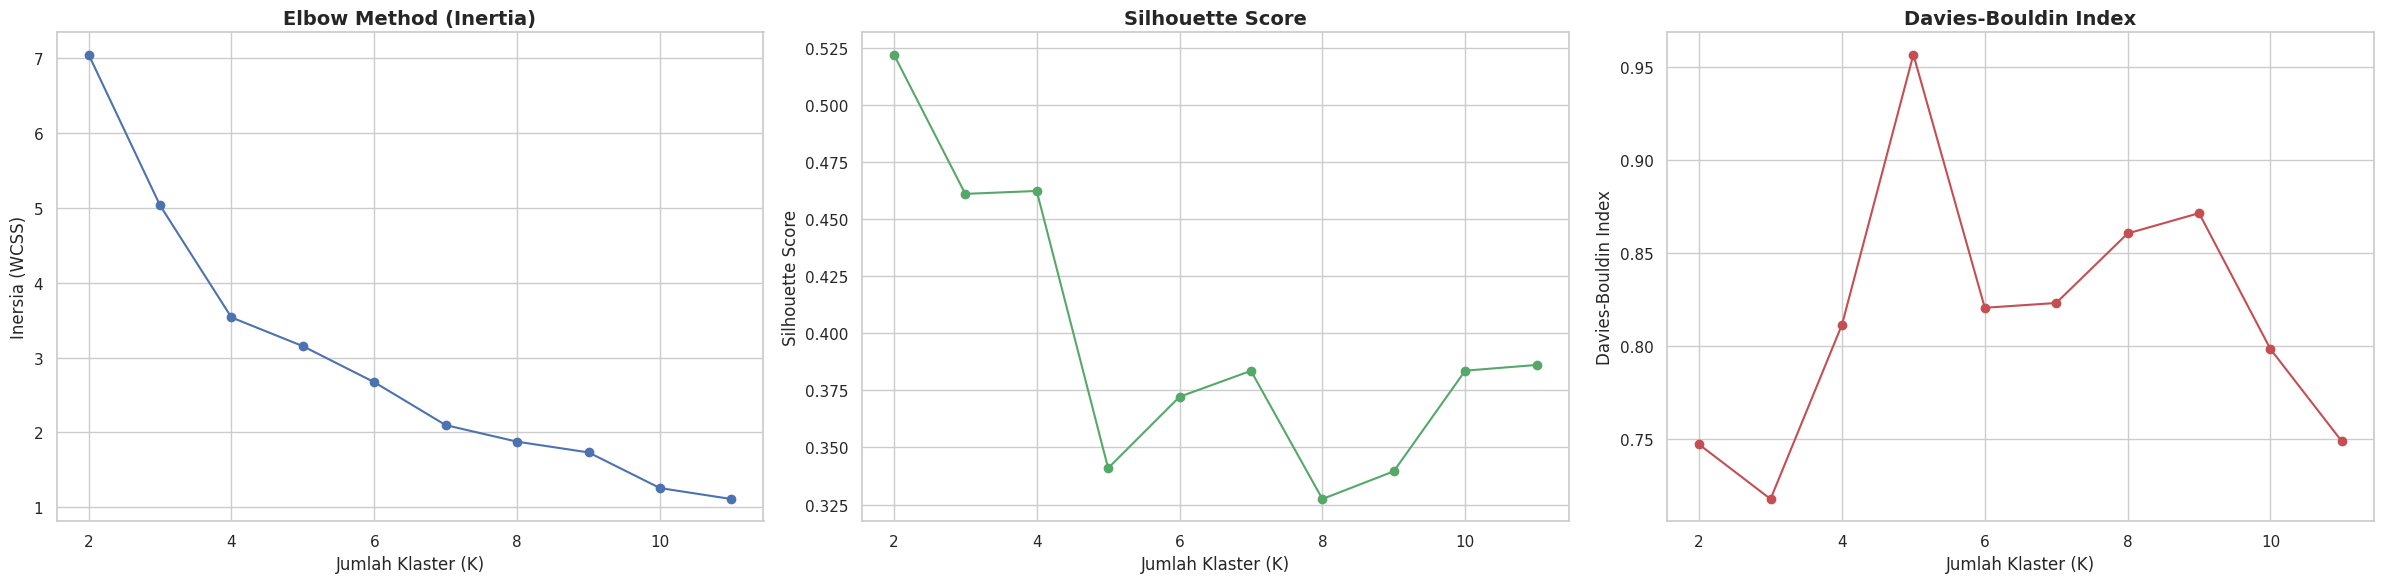

In [ ]:
# --- Memuat Data Hasil Preprocessing ---
dataKlaster = pd.read_csv('dataScaled.csv')

# Siapkan data untuk clustering (4 fitur hasil scaling)
fiturUntukKlaster = [
    'Angka Harapan Hidup (AHH)_Scaled',
    'Rata-Rata Lama Sekolah (RLS)_Scaled',
    'Pengeluaran per Kapita Disesuaikan (PPP)_Scaled',
    'Indeks Pembangunan Manusia (IPM)_Scaled'
]
dataUntukKlaster = dataKlaster[fiturUntukKlaster].values

# --- Penentuan Jumlah Klaster (K) Optimal ---
print("--- Menentukan Jumlah Klaster Optimal (K) ---")
rentangK = range(2, 12)
inersia = []
skorSiluet = []
skorDaviesBouldin = []

for k in rentangK:
    # Inisialisasi dan latih model KMeans
    modelKMeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    modelKMeans.fit(dataUntukKlaster)

    # Dapatkan label klaster
    label = modelKMeans.labels_

    # Simpan metrik evaluasi
    inersia.append(modelKMeans.inertia_)
    skorSiluet.append(silhouette_score(dataUntukKlaster, label))
    skorDaviesBouldin.append(davies_bouldin_score(dataUntukKlaster, label))

# Visualisasi hasil evaluasi untuk berbagai nilai K
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot Elbow Method (Inertia/WCSS)
axes[0].plot(rentangK, inersia, 'bo-')
axes[0].set_title('Elbow Method (Inertia)', fontsize=14, weight='bold')
axes[0].set_xlabel('Jumlah Klaster (K)')
axes[0].set_ylabel('Inersia (WCSS)')

# Plot Silhouette Score
axes[1].plot(rentangK, skorSiluet, 'go-')
axes[1].set_title('Silhouette Score', fontsize=14, weight='bold')
axes[1].set_xlabel('Jumlah Klaster (K)')
axes[1].set_ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
axes[2].plot(rentangK, skorDaviesBouldin, 'ro-')
axes[2].set_title('Davies-Bouldin Index', fontsize=14, weight='bold')
axes[2].set_xlabel('Jumlah Klaster (K)')
axes[2].set_ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

In [ ]:
# --- Evaluasi Hasil Klasterisasi ---

# Cetak semua skor evaluasi
print("\n--- Evaluasi K untuk Setiap Metrik ---")
print(f"{'K':<5}{'Inertia':<15}{'Silhouette':<15}{'Davies-Bouldin':<20}")
for i, k in enumerate(rentangK):
    print(f"{k:<5}{inersia[i]:<15.2f}{skorSiluet[i]:<15.4f}{skorDaviesBouldin[i]:<20.4f}")

# Tentukan K optimal berdasarkan dua metrik:
# 1. Silhouette Score maksimum
# 2. Davies-Bouldin Index minimum

# K dengan silhouette tertinggi
k_silhouette = rentangK[np.argmax(skorSiluet)]
# K dengan Davies-Bouldin Index terendah
k_dbi = rentangK[np.argmin(skorDaviesBouldin)]

print(f"\nBerdasarkan Silhouette Score tertinggi → K optimal = {k_silhouette}")
print(f"Berdasarkan Davies-Bouldin Index terendah → K optimal = {k_dbi}")

# --- Tentukan K final ---
# Jika keduanya sama, langsung pakai
# Jika berbeda, pilih salah satu atau kompromi (misalnya pakai Silhouette karena lebih stabil)
kOptimal = k_dbi  # atau bisa pakai k_dbi atau rumus kompromi jika kamu mau
print(f"\nJumlah klaster yang digunakan (berdasarkan evaluasi) adalah: {kOptimal}")

# --- Penerapan Model K-Means dengan K Optimal ---
print(f"\nMenerapkan clustering dengan K={kOptimal}...")

# Latih model final dengan K optimal
modelFinal = KMeans(n_clusters=kOptimal, n_init='auto', random_state=42)
labelPrediksi = modelFinal.fit_predict(dataUntukKlaster)

# Tambahkan hasil label klaster ke DataFrame
dataKlaster['Klaster'] = labelPrediksi



--- Evaluasi K untuk Setiap Metrik ---
K    Inertia        Silhouette     Davies-Bouldin      
2    7.05           0.5219         0.7470              
3    5.04           0.4610         0.7177              
4    3.54           0.4622         0.8114              
5    3.15           0.3410         0.9564              
6    2.67           0.3722         0.8204              
7    2.10           0.3835         0.8230              
8    1.88           0.3274         0.8603              
9    1.73           0.3396         0.8713              
10   1.26           0.3836         0.7983              
11   1.11           0.3861         0.7487              

Berdasarkan Silhouette Score tertinggi → K optimal = 2
Berdasarkan Davies-Bouldin Index terendah → K optimal = 3

Jumlah klaster yang digunakan (berdasarkan evaluasi) adalah: 3

Menerapkan clustering dengan K=3...


In [ ]:
# --- Analisis dan Pengurutan Hasil Klaster ---
# Agar label klaster lebih bermakna (0=terendah, 1=menengah, dst.), kita urutkan berdasarkan rata-rata IPM
rerataIpmPerKlaster = dataKlaster.groupby('Klaster')['Indeks Pembangunan Manusia (IPM)_Scaled'].mean().sort_values()

# Buat pemetaan dari label acak ke label berurutan
pemetaanKlaster = {labelAsli: labelBaru for labelBaru, labelAsli in enumerate(rerataIpmPerKlaster.index)}

# Terapkan pemetaan ke kolom Klaster
dataKlaster['Klaster'] = dataKlaster['Klaster'].map(pemetaanKlaster)

# Urutkan hasil akhir agar mudah dibaca
dataKlaster = dataKlaster.sort_values(by=['Klaster', 'Provinsi']).reset_index(drop=True)

dataKlaster.to_csv('hasilClustering.csv', index=False)

print(f"\nClustering selesai. Data hasil clustering disimpan ke hasilClustering.csv\n")
print("--- Tabel Hasil Akhir Clustering ---\n")
#print(dataKlaster.to_string(index=False))

display(dataKlaster.head(150).style.hide(axis="index"))


Clustering selesai. Data hasil clustering disimpan ke hasilClustering.csv

--- Tabel Hasil Akhir Clustering ---



Provinsi,Angka Harapan Hidup (AHH)_Scaled,Rata-Rata Lama Sekolah (RLS)_Scaled,Pengeluaran per Kapita Disesuaikan (PPP)_Scaled,Indeks Pembangunan Manusia (IPM)_Scaled,Klaster
GORONTALO 2022,0.328306,0.514867,0.349572,0.508899,0
GORONTALO 2023,0.359629,0.528951,0.376386,0.528151,0
GORONTALO 2024,0.386311,0.553991,0.409378,0.554668,0
MALUKU 2022,0.321346,0.824726,0.222448,0.651653,0
MALUKU 2023,0.354988,0.826291,0.250667,0.665819,0
MALUKU 2024,0.381671,0.835681,0.279166,0.683255,0
MALUKU UTARA 2022,0.357309,0.704225,0.188895,0.580458,0
MALUKU UTARA 2023,0.390951,0.705790,0.219500,0.596077,0
MALUKU UTARA 2024,0.424594,0.719875,0.253615,0.618598,0
NUSA TENGGARA BARAT 2022,0.495360,0.502347,0.349151,0.524155,0


In [ ]:
# --- 4. EVALUASI CLUSTERING ---

# --- Memuat Data Hasil Clustering ---
dataHasil = pd.read_csv('hasilClustering.csv')

# Ambil semua fitur yang digunakan dalam clustering (harus yang scaled)
fiturYangDigunakan = [
    'Indeks Pembangunan Manusia (IPM)_Scaled',
    'Angka Harapan Hidup (AHH)_Scaled',
    'Rata-Rata Lama Sekolah (RLS)_Scaled',
    'Pengeluaran per Kapita Disesuaikan (PPP)_Scaled'
]

dataUntukMetrik = dataHasil[fiturYangDigunakan].values
labelKlaster = dataHasil['Klaster'].values

# --- Perhitungan Metrik Kuantitatif ---
print("--- Menghitung Metrik Evaluasi ---")

# 1. Inertia (Within-Cluster Sum of Squares)
kOptimal = dataHasil['Klaster'].nunique()
modelFinal = KMeans(n_clusters=kOptimal, n_init='auto', random_state=42)
modelFinal.fit(dataUntukMetrik)
nilaiInersia = modelFinal.inertia_
print(f"Inertia (WCSS): {nilaiInersia:.2f}")

# 2. Silhouette Score
skorSiluet = silhouette_score(dataUntukMetrik, labelKlaster)
print(f"Silhouette Score: {skorSiluet:.4f}")

# 3. Davies-Bouldin Index
skorDaviesBouldin = davies_bouldin_score(dataUntukMetrik, labelKlaster)
print(f"Davies-Bouldin Index: {skorDaviesBouldin:.4f}")


--- Menghitung Metrik Evaluasi ---
Inertia (WCSS): 5.45
Silhouette Score: 0.4610
Davies-Bouldin Index: 0.7177


In [ ]:
# --- ANALISIS PERGERAKAN KLASTER ---

# Muat data hasil clustering
dataHasil = pd.read_csv('hasilClustering.csv')

dataHasil['Tahun'] = pd.to_numeric(dataHasil['Provinsi'].str[-4:])
dataHasil['NamaProvinsi'] = dataHasil['Provinsi'].str[:-5]

tabelPerubahan = dataHasil.pivot_table(
    index='NamaProvinsi',
    columns='Tahun',
    values='Klaster'
).rename_axis(index='Provinsi', columns=None)

# --- Analisis Tren Kenaikan, Stagnan, atau Penurunan ---
def tentukanTren(row):
    # Periksa apakah data untuk tahun awal dan akhir tersedia
    if pd.notna(row[2022]) and pd.notna(row[2024]):
        if row[2024] > row[2022]:
            return 'Peningkatan'
        elif row[2024] < row[2022]:
            return 'Penurunan'
        else:
            return 'Stagnan'

tabelPerubahan['Tren'] = tabelPerubahan.apply(tentukanTren, axis=1)

# Tampilkan tabel utama
print("--- Tabel Perubahan Klaster Provinsi (2022-2024) ---")
display(tabelPerubahan[[2022, 2023, 2024, 'Tren']].rename(columns={2022:'Klaster 2022', 2023:'Klaster 2023', 2024:'Klaster 2024'}))

--- Tabel Perubahan Klaster Provinsi (2022-2024) ---


,Klaster 2022,Klaster 2023,Klaster 2024,Tren
Provinsi,,,,
ACEH,1.0,1.0,1.0,Stagnan
BALI,2.0,2.0,2.0,Stagnan
BANTEN,1.0,1.0,1.0,Stagnan
BENGKULU,1.0,1.0,1.0,Stagnan
DI YOGYAKARTA,2.0,2.0,2.0,Stagnan
DKI JAKARTA,2.0,2.0,2.0,Stagnan
GORONTALO,0.0,0.0,0.0,Stagnan
JAMBI,1.0,1.0,1.0,Stagnan
JAWA BARAT,1.0,1.0,1.0,Stagnan


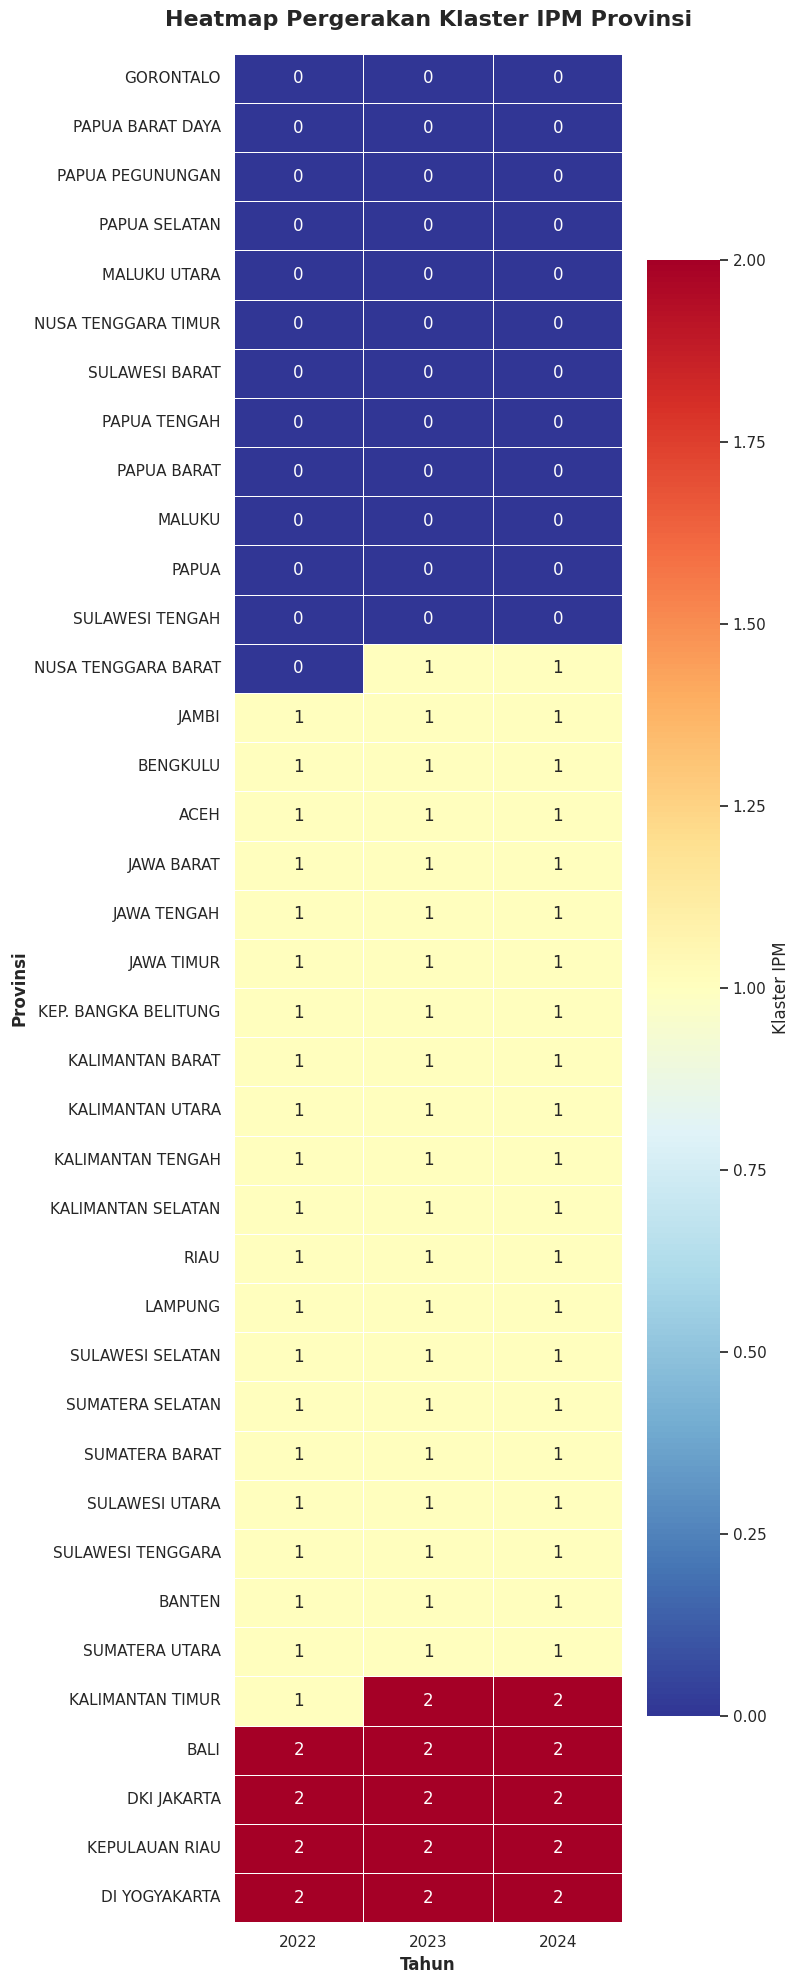

In [ ]:
# --- VISUALISASI HEATMAP PERGERAKAN KLASTER ---

# Ekstrak tahun dan nama provinsi
dataHasil['Tahun'] = pd.to_numeric(dataHasil['Provinsi'].str[-4:])
dataHasil['NamaProvinsi'] = dataHasil['Provinsi'].str[:-5]

# Buat pivot table untuk pergerakan klaster
tabelPergerakan = dataHasil.pivot_table(
    index='NamaProvinsi',
    columns='Tahun',
    values='Klaster'
).rename_axis(index='Provinsi', columns=None)

# Urutkan berdasarkan rata-rata klaster atau klaster di tahun terakhir
tabelPergerakan['RataRata'] = tabelPergerakan.mean(axis=1)
tabelPergerakan = tabelPergerakan.sort_values('RataRata').drop('RataRata', axis=1)

# --- HEATMAP PERGERAKAN KLASTER ---
plt.figure(figsize=(8, 20))

# Buat heatmap
sns.heatmap(tabelPergerakan[[2022, 2023, 2024]],
            annot=True, fmt='.0f', cmap='RdYlBu_r',
            cbar_kws={'label': 'Klaster IPM'},
            linewidths=0.5)

plt.title('Heatmap Pergerakan Klaster IPM Provinsi',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tahun', fontsize=12, fontweight='bold')
plt.ylabel('Provinsi', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()